In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Load IMDB Dataset of 50K Movie Reviews

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It provides a set of 50,000 highly polar movie reviews.

Download data from : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
# base_csv = 'data/IMDB Dataset.csv'
base_csv = '/content/drive/MyDrive/ENSIM_S7/IA/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Splitting to train and test data

We select only 10000 reviews (samples) to be able to work in real time woth our calculation capacity.

In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X[:10000],y[:10000])
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (7500,)
shape of test data is (2500,)


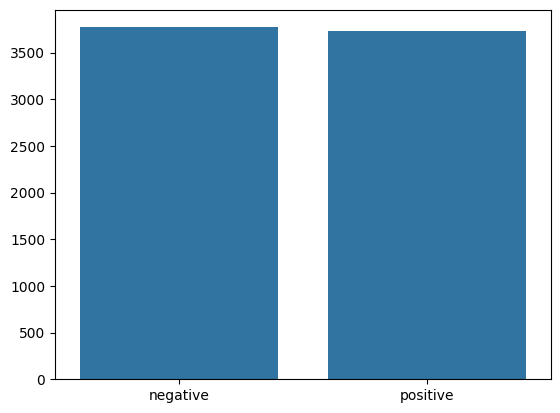

Number of samples in the Negative and Positive class


In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()
print("Number of samples in the Negative and Positive class")

## Preprocessing text data

### Vectorization

Word Embeddings or Word vectorization is a methodology in NLP to map words or phrases from vocabulary to a corresponding vector of real numbers which used to find word predictions, word similarities/semantics.

**The process of converting words into numbers are called Vectorization.**

**One Hot Encoding:**
If you have been wo tabular data, one hot encoding must not be a big deal for you! One hot encoding is simply a binary representation of the words in the vocabulary. If there are 25 words in the vocabulary, we will have a vector of length 25, with '1' at the position index of the word, and '0s' at all the other position. A simple example representation is given below, where 5 words are there on the vocabulary¶

![image.png](attachment:fd26f729-0365-4fe0-96d4-bcbb0512ec70.png)


In order to vectorize reviews in the dataset, we propose to follow below steps:

1. Remove all non_word characters (everything except numbers and letters)
2. Create a list of all words in dataset
3. Count number of each word and make a sorted list for a pair of (word, frequency)
4. Selecting 500 most frequent words in dataset as dictionary with accompany of their one-hot vector. It means all 500 frequent words would be represented by a vector with size of 500 which contain one time 1 and the rest is 0.
5. Remove the rest of words that are not in the dictionary
6. convert all reviews to a sequence of one-hot vectors.

In [6]:
# 1. Remove all non-word characters (everything except numbers and letters)
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

##################
#2. Create a list of all words in dataset
##################
word_list = []

stop_words = set(stopwords.words('english'))
for sent in x_train:
    for word in sent.lower().split():
        word = preprocess_string(word)
        ##################
        #1. Remove all non-word characters
        ##################
        if word not in stop_words and word != '':
            word_list.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
##################
#3. Count number of each word and make a sorted list for a pair of (word, frequency)
##################
corpus = Counter(word_list)
##################
#4. Selecting 1000 most frequent words in dataset as dictionary with accompany of their one-hot vector.
#It means all 1000 frequent words would be represented by a vector with size of 1000 which contain one time 1 and the rest is 0.
##################
NUM_DICT=500
# sorting on the basis of most common words
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:NUM_DICT]
# creating a dict
onehot_dict={}
for i,w in enumerate(corpus_):
    one_hot=np.zeros(NUM_DICT)
    one_hot[i]=1
    onehot_dict[w]=one_hot

print(f'Length of vocabulary is {len(onehot_dict)}')

def vectorization(x,y,onehot_dict):

    ##################
    # 5. Remove the rest of words that are not in the dictionary
    ##################

    #On convertit un texte en séquence de vecteurs
    encoded_x=[onehot_dict[preprocess_string(word)] for word in x.lower().split()
                             if preprocess_string(word) in onehot_dict.keys()]

    # convert the positive class to 1 and negative class to 0
    encoded_y = 1 if y =='positive' else 0
    return np.array(encoded_x), np.array(encoded_y)

Length of vocabulary is 500


### Padding

Now we will pad each of the sequence to max length (we chose 500)

In [9]:
def padding_(sentence, seq_len,dic_size=NUM_DICT):
    # on ajoute un des zéros au début pour que la taille max soit atteinte
    features = np.zeros((seq_len,dic_size),dtype=int) # création d'une matrice de zéros de taille max
    features[-min(seq_len,len(sentence)):] = np.array(sentence)[:seq_len] # on insert la phrase à partir de la fin de la matrice de 0
    return features

### Create a tensor dataset and DataLoader

In [10]:
import os
import pandas as pd

class CustomDataset():
    def __init__(self,x,y,onehot_dict, seq_len=500,dict_size=NUM_DICT):
        self.y = y
        self.x = x
        self.max_len = seq_len
        self.dict_size = dict_size
        self.onehot_dict=onehot_dict

    def __len__(self):
        return len(self.y)

    def padding_(self,sentence):
        features = np.zeros((self.max_len,self.dict_size),dtype=int)
        features[-min(self.max_len,len(sentence)):] = np.array(sentence)[:self.max_len]
        return features

    def __getitem__(self, idx):
        x_vec,y_vec=vectorization(self.x[idx],self.y[idx],self.onehot_dict)
        x_vec_pad=self.padding_(x_vec)
        return torch.from_numpy(x_vec_pad), torch.from_numpy(y_vec)

In [11]:
MAX_LEN=50
# create Tensor datasets
train_data = CustomDataset(x_train, y_train,onehot_dict, seq_len=MAX_LEN,dict_size=NUM_DICT)
valid_data = CustomDataset(x_test, y_test,onehot_dict, seq_len=MAX_LEN,dict_size=NUM_DICT)

# dataloaders
batch_size = 100

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [12]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length | Sample input size:  torch.Size([100, 50, 500]) - batch size, nb mots, taille de chaque mot (vecteur de 500)
print('Sample output size:', sample_y.size())

Sample input size:  torch.Size([100, 50, 500])
Sample output size: torch.Size([100])


# RNN Network

In [13]:
# @title
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device\n")

Using cuda device



In [14]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,hidden_dim,embedding_dim,dropout_prob=0.3):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        lstm_out, hidden = self.lstm(x, hidden)
        out = self.fc(lstm_out)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [14]:


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()/len(label.squeeze())


def train(dataloader, model, loss_fn, opt,clip):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    # initialize hidden state
    batch_size=int(size/num_batches)
    h = model.init_hidden(batch_size)
    for batch, (inputs, labels) in enumerate(dataloader):

        inputs, labels = inputs.float().to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return model,opt

def test(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    batch_size=int(size/num_batches)
    val_losses = []
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        val_h = model.init_hidden(batch_size)
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in val_h])

            model.zero_grad()
            output,h = model(inputs,h)
#             import pdb
#             pdb.set_trace()
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    print(f"Test Accuracy: {100*(val_acc/num_batches):>0.1f}%, Avg loss: {np.mean(val_losses):>8f} \n")

In [16]:
no_layers = 2
vocab_size = 1#len(vocab) + 1 #extra 1 for padding
embedding_dim = NUM_DICT
output_dim = 1
hidden_dim = 256

model_1 = SentimentRNN(no_layers,hidden_dim,embedding_dim)

#moving to gpu
model_1.to(device)
print(model_1)
total_params = sum(p.numel() for p in model_1.parameters())
print(f"Number of Parameters:{total_params}")

SentimentRNN(
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
Number of Parameters:1302785


In [17]:
# loss and optimization functions
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

clip = 5
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_1,optimizer = train(train_loader, model_1, criterion, optimizer,clip)
    test(valid_loader, model_1, criterion)
print("Done!")


Epoch 1
-------------------------------
loss: 0.692151  [    0/ 7500]
loss: 0.693047  [ 1000/ 7500]
loss: 0.692448  [ 2000/ 7500]
loss: 0.689121  [ 3000/ 7500]
loss: 0.684621  [ 4000/ 7500]
loss: 0.685182  [ 5000/ 7500]
loss: 0.627044  [ 6000/ 7500]
loss: 0.543097  [ 7000/ 7500]
Test Accuracy: 77.1%, Avg loss: 0.483918 

Epoch 2
-------------------------------
loss: 0.531476  [    0/ 7500]
loss: 0.466304  [ 1000/ 7500]
loss: 0.507832  [ 2000/ 7500]
loss: 0.489812  [ 3000/ 7500]
loss: 0.563041  [ 4000/ 7500]
loss: 0.408733  [ 5000/ 7500]
loss: 0.425679  [ 6000/ 7500]
loss: 0.384519  [ 7000/ 7500]
Test Accuracy: 80.3%, Avg loss: 0.418647 

Epoch 3
-------------------------------
loss: 0.442498  [    0/ 7500]
loss: 0.474232  [ 1000/ 7500]
loss: 0.356706  [ 2000/ 7500]
loss: 0.388990  [ 3000/ 7500]
loss: 0.374053  [ 4000/ 7500]
loss: 0.504594  [ 5000/ 7500]
loss: 0.417949  [ 6000/ 7500]
loss: 0.430369  [ 7000/ 7500]
Test Accuracy: 79.2%, Avg loss: 0.465764 

Epoch 4
-----------------------

<div style="border: solid 3px #000;">
    <h1 style="text-align: center; color:#000; font-family:Georgia; font-size:26px;">Exercise :</h1>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 1. Change the one hot vector in the preprocessing to a number. It means instead of converting each word to a vector, each word should be represented by a unique integer value. </h1>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 2. Consequently, change the CustomDataset and its padding function to one 1D sequential data.  </h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 3. Add an embedding layer at the beginning of the network with embedding size of 64. nn.Embedding(vocab_size, embedding_size)  </h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 4. Add a dropout layer before the last fully connected layer. nn.Dropout(0.3)</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 5. Change LSTM layer with a GRU layer. The init_hidden function should be changed and return only h0, Why?</h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 6. Compare with previous version the number of parameters, the performance in terms of final test accuracy and the convergence of model.</h1>
    <p style='text-align: left;'> </p>
</div>

In [15]:
nb_dict = {}
for i,w in enumerate(corpus_):
    nb_dict[w]=i

print(f'Length of vocabulary is {len(nb_dict)}')
print(nb_dict)

def vectorization(x,y,nb_dict):

    ##################
    # 5. Remove the rest of words that are not in the dictionary
    ##################
    encoded_x=[nb_dict[preprocess_string(word)] for word in x.lower().split()
                             if preprocess_string(word) in onehot_dict.keys()]

    # convert the positive class to 1 and negative class to 0
    encoded_y = 1 if y =='positive' else 0
    return np.array(encoded_x), np.array(encoded_y)

Length of vocabulary is 500
{'br': 0, 'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'would': 6, 'even': 7, 'time': 8, 'story': 9, 'see': 10, 'really': 11, 'well': 12, 'much': 13, 'get': 14, 'great': 15, 'bad': 16, 'people': 17, 'also': 18, 'first': 19, 'dont': 20, 'movies': 21, 'made': 22, 'make': 23, 'way': 24, 'films': 25, 'could': 26, 'characters': 27, 'think': 28, 'watch': 29, 'little': 30, 'never': 31, 'many': 32, 'show': 33, 'two': 34, 'character': 35, 'seen': 36, 'love': 37, 'acting': 38, 'plot': 39, 'best': 40, 'know': 41, 'life': 42, 'ever': 43, 'better': 44, 'say': 45, 'still': 46, 'scene': 47, 'end': 48, 'scenes': 49, 'something': 50, 'go': 51, 'man': 52, 'real': 53, 'im': 54, 'back': 55, 'watching': 56, 'doesnt': 57, 'actors': 58, 'look': 59, 'didnt': 60, 'actually': 61, 'though': 62, 'funny': 63, 'thing': 64, 'years': 65, 'makes': 66, 'nothing': 67, 'work': 68, 'going': 69, 'another': 70, 'every': 71, 'lot': 72, 'director': 73, 'us': 74, 'new': 75, 'old': 76, 'pre

In [16]:
class CustomDataset():
    def __init__(self,x,y,nb_dict, seq_len=500,dict_size=NUM_DICT):
        self.y = y
        self.x = x
        self.max_len = seq_len
        self.dict_size = dict_size
        self.nb_dict=nb_dict

    def __len__(self):
        return len(self.y)

    def padding_(self,sentence):
        features = np.zeros((self.max_len),dtype=int)
        features[-min(self.max_len,len(sentence)):] = np.array(sentence)[:self.max_len]
        return features

    def __getitem__(self, idx):
        x_vec,y_vec=vectorization(self.x[idx],self.y[idx],self.nb_dict)
        x_vec_pad=self.padding_(x_vec)
        return torch.from_numpy(x_vec_pad), torch.from_numpy(y_vec)

In [17]:
MAX_LEN=50
# create Tensor datasets
train_data = CustomDataset(x_train, y_train,nb_dict, seq_len=MAX_LEN,dict_size=NUM_DICT)
valid_data = CustomDataset(x_test, y_test,nb_dict, seq_len=MAX_LEN,dict_size=NUM_DICT)

# dataloaders
batch_size = 100

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [18]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample output size:', sample_y.size())

Sample input size:  torch.Size([100, 50])
Sample output size: torch.Size([100])


In [19]:
# @title
def train2(dataloader, model, loss_fn, opt,clip):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    # initialize hidden state
    batch_size=int(size/num_batches)
    h_init = model.init_hidden(batch_size)
    for batch, (inputs, labels) in enumerate(dataloader):

        inputs, labels = inputs.float().to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        # h = [each.data for each in h]

        model.zero_grad()
        output,h = model(inputs,h_init)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return model,opt

def test2(test_dataloader, model, loss_fn):
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    batch_size=int(size/num_batches)
    val_losses = []
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        val_h = model.init_hidden(batch_size)
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.float().to(device), labels.to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history

            model.zero_grad()
            output,h = model(inputs,val_h)
#             import pdb
#             pdb.set_trace()
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    print(f"Test Accuracy: {100*(val_acc/num_batches):>0.1f}%, Avg loss: {np.mean(val_losses):>8f} \n")

In [22]:
class SentimentRNN2(nn.Module):
    def __init__(self,no_layers,hidden_dim,embedding_dim,dropout_prob=0.3):
        super(SentimentRNN2,self).__init__()
        # print(no_layers, hidden_dim, embedding_dim)
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.dropout = nn.Dropout(dropout_prob)

        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # print(x.shape)
        # embeddings and lstm_out
        # print(x.type(torch.LongTensor).to(device))
        embedding_out = self.embedding(x.type(torch.LongTensor).to(device))
        # print(x.shape, hidden.shape)
        gru_out, hidden = self.gru(embedding_out, hidden)


        dropout_out = self.dropout(gru_out)
        out = self.fc(dropout_out)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return h0

no_layers = 2
vocab_size = len(nb_dict)
print(vocab_size)
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model_2 = SentimentRNN2(no_layers,hidden_dim,embedding_dim)

#moving to gpu
model_2.to(device)
print(model_2)
total_params = sum(p.numel() for p in model_2.parameters())
print(f"Number of Parameters:{total_params}")

500
SentimentRNN2(
  (embedding): Embedding(500, 64)
  (dropout): Dropout(p=0.3, inplace=False)
  (gru): GRU(64, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
Number of Parameters:674305


In [23]:
# loss and optimization functions
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

clip = 5
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_2,optimizer = train2(train_loader, model_2, criterion, optimizer,clip)
    test2(valid_loader, model_2, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.698437  [    0/ 7500]
loss: 0.695232  [ 1000/ 7500]
loss: 0.643265  [ 2000/ 7500]
loss: 0.598354  [ 3000/ 7500]
loss: 0.710737  [ 4000/ 7500]
loss: 0.545110  [ 5000/ 7500]
loss: 0.527979  [ 6000/ 7500]
loss: 0.603132  [ 7000/ 7500]
Test Accuracy: 73.0%, Avg loss: 0.545490 

Epoch 2
-------------------------------
loss: 0.576568  [    0/ 7500]
loss: 0.600731  [ 1000/ 7500]
loss: 0.565958  [ 2000/ 7500]
loss: 0.574620  [ 3000/ 7500]
loss: 0.469503  [ 4000/ 7500]
loss: 0.432824  [ 5000/ 7500]
loss: 0.439395  [ 6000/ 7500]
loss: 0.481654  [ 7000/ 7500]
Test Accuracy: 73.1%, Avg loss: 0.560695 

Epoch 3
-------------------------------
loss: 0.496726  [    0/ 7500]
loss: 0.558410  [ 1000/ 7500]
loss: 0.486320  [ 2000/ 7500]
loss: 0.382431  [ 3000/ 7500]
loss: 0.530906  [ 4000/ 7500]
loss: 0.431985  [ 5000/ 7500]
loss: 0.384125  [ 6000/ 7500]
loss: 0.555818  [ 7000/ 7500]
Test Accuracy: 77.9%, Avg loss: 0.470435 

Epoch 4
-----------------------

<div style="border: solid 3px #000;">
    <h1 style="text-align: center; color:#000; font-family:Georgia; font-size:26px;">Exercise :</h1>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 1. We would like to add a convolutional layer after embedding layer and before LSTM layer. Why we should use 1D convolutional layer instead of 2D?</h1>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 2. Conv1d would be applied to the last axis of data. In order to apply the convolution operation on the axis of words order we can change the shape of data by using x.permute(0, 2, 1); the command would change the shape of x by exchanging the second and third dimension.  </h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 3. Add a MaxPool1d after Conv1d layer </h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 4. By applying x.permute(0, 2, 1) once again on the output of the MaxPool1d layer, change the dimensions order to the original form. </h1>
    <p style='text-align: left;'> </p>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 5. Compare with previous version the number of parameters, training time (what has changed?) the performance in terms of final test accuracy and the convergence of model.</h1>
    <h1 style="text-align: left; color:#000; font-family:Courier; font-size:16px;"> &emsp; 6. Check if the model has been overfitted.</h1>
    <p style='text-align: left;'> </p>
</div>

In [69]:
# Your code is missing here
class SentimentRNN3(nn.Module):
    def __init__(self,no_layers,hidden_dim,embedding_dim,dropout_prob=0.3):
        super(SentimentRNN3,self).__init__()
        # print(no_layers, hidden_dim, embedding_dim)
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1d = nn.Conv1d(in_channels=50, out_channels=400, kernel_size=2)
        self.maxpool1d = nn.MaxPool1d(kernel_size = 2, stride = 2)

        self.gru = nn.GRU(input_size=32,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(dropout_prob)
        # linear and sigmoid layer

        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embedding_out = self.embedding(x.type(torch.LongTensor).to(device))
        # print("Embedding out:", embedding_out.shape)
        embedding_out.permute(0, 2, 1)
        conv_out = self.conv1d(embedding_out)
        # print("Convolution out:", conv_out.shape)
        maxpool_out = self.maxpool1d(conv_out)
        # print("Maxpool out:", maxpool_out.shape)
        maxpool_out.permute(0, 2, 1)

        gru_out, hidden = self.gru(maxpool_out, hidden)
        # print("GRU out:", gru_out.shape)


        dropout_out = self.dropout(gru_out)
        # print("Dropout out:", dropout_out.shape)
        out = self.fc(dropout_out)
        # print("FC out:", out.shape)
        # sigmoid function
        sig_out = self.sig(out)
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return h0

no_layers = 2
vocab_size = len(nb_dict)
print(vocab_size)
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model_3 = SentimentRNN3(no_layers,hidden_dim,embedding_dim)

#moving to gpu
model_3.to(device)
print(model_3)
total_params = sum(p.numel() for p in model_3.parameters())
print(f"Number of Parameters:{total_params}")

500
SentimentRNN3(
  (embedding): Embedding(500, 64)
  (conv1d): Conv1d(50, 400, kernel_size=(2,), stride=(1,))
  (maxpool1d): MaxPool1d(kernel_size=4, stride=2, padding=2, dilation=1, ceil_mode=False)
  (gru): GRU(32, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)
Number of Parameters:690129


In [ ]:
# loss and optimization functions
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=lr)

clip = 5
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_3,optimizer = train2(train_loader, model_3, criterion, optimizer,clip)
    test2(valid_loader, model_3, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.691735  [    0/ 7500]
loss: 0.689545  [ 1000/ 7500]
loss: 0.695495  [ 2000/ 7500]
loss: 0.694594  [ 3000/ 7500]
loss: 0.685647  [ 4000/ 7500]
loss: 0.686828  [ 5000/ 7500]
loss: 0.693655  [ 6000/ 7500]
loss: 0.687612  [ 7000/ 7500]
Test Accuracy: 51.9%, Avg loss: 0.691843 

Epoch 2
-------------------------------
loss: 0.696832  [    0/ 7500]
loss: 0.696760  [ 1000/ 7500]
loss: 0.691424  [ 2000/ 7500]
loss: 0.672842  [ 3000/ 7500]
loss: 0.699928  [ 4000/ 7500]
loss: 0.685872  [ 5000/ 7500]
loss: 0.681117  [ 6000/ 7500]
loss: 0.674511  [ 7000/ 7500]
Test Accuracy: 54.5%, Avg loss: 0.688049 

Epoch 3
-------------------------------
loss: 0.668083  [    0/ 7500]
loss: 0.658467  [ 1000/ 7500]
loss: 0.660166  [ 2000/ 7500]
loss: 0.556921  [ 3000/ 7500]
loss: 0.661838  [ 4000/ 7500]
loss: 0.633133  [ 5000/ 7500]
loss: 0.672400  [ 6000/ 7500]
loss: 0.670829  [ 7000/ 7500]
Test Accuracy: 61.3%, Avg loss: 0.650625 

Epoch 4
-----------------------